In [59]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from IPython.display import HTML, Video
from moviepy.editor import VideoFileClip

In [60]:
debug_mode = 0

In [61]:
def threshold_rel(img, lo, hi):
    vmin = np.min(img)
    vmax = np.max(img)
    
    vlo = vmin + (vmax - vmin) * lo
    vhi = vmin + (vmax - vmin) * hi
    return np.uint8((img >= vlo) & (img <= vhi)) * 255

def threshold_abs(img, lo, hi):
    return np.uint8((img >= lo) & (img <= hi)) * 255

class Thresholding:
    """ This class is for extracting relevant pixels in an image.
    """
    def __init__(self):
        """ Init Thresholding."""
        pass

    def forward(self, img):
        """ Take an image and extract all relavant pixels.

        Parameters:
            img (np.array): Input image

        Returns:
            binary (np.array): A binary image represent all positions of relavant pixels.
        """
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        h_channel = hls[:,:,0]
        l_channel = hls[:,:,1]
        s_channel = hls[:,:,2]
        v_channel = hsv[:,:,2]

        right_lane = threshold_rel(l_channel, 0.8, 1.0)  
        # darkened the right lane -- > b2a wade7 aktar 
        right_lane[:,:750] = 0

        left_lane = threshold_abs(h_channel, 20, 30)       
        left_lane &= threshold_rel(v_channel, 0.7, 1.0)
        # Remove Noise on the right
        left_lane[:,550:] = 0
        img2 = left_lane | right_lane
        if debug_mode == 1:
            th = img2
            th = np.dstack((th, th, th))
            plt.imsave('thresholded.jpg', th)
        return img2

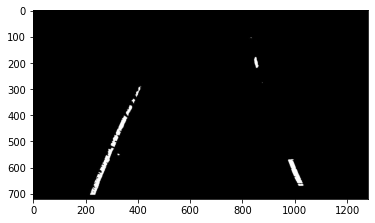

In [62]:
img = cv2.imread('thresholded.jpg')
plt.imshow(img, cmap='gray')

In [63]:
class PerspectiveTransformation:
    """ This a class for transforming image between front view and top view

    Attributes:
        src (np.array): Coordinates of 4 source points
        dst (np.array): Coordinates of 4 destination points
        M (np.array): Matrix to transform image from front view to top view
        M_inv (np.array): Matrix to transform image from top view to front view
    """
    def __init__(self):
        """Init PerspectiveTransformation."""
        self.src = np.float32([(550, 460),     # top-left
                               (150, 720),     # bottom-left
                               (1200, 720),    # bottom-right
                               (770, 460)])    # top-right
        self.dst = np.float32([(100, 0),
                               (100, 720),
                               (1100, 720),
                               (1100, 0)])
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.M_inv = cv2.getPerspectiveTransform(self.dst, self.src)

    def forward(self, img, img_size=(1280, 720), flags=cv2.INTER_LINEAR):
        """ Take a front view image and transform to top view

        Parameters:
            img (np.array): A front view image
            img_size (tuple): Size of the image (width, height)
            flags : flag to use in cv2.warpPerspective()

        Returns:
            Image (np.array): Top view image
        """
        return cv2.warpPerspective(img, self.M, img_size, flags=flags)

    def backward(self, img, img_size=(1280, 720), flags=cv2.INTER_LINEAR):
        """ Take a top view image and transform it to front view

        Parameters:
            img (np.array): A top view image
            img_size (tuple): Size of the image (width, height)
            flags (int): flag to use in cv2.warpPerspective()

        Returns:
            Image (np.array): Front view image
        """
        return cv2.warpPerspective(img, self.M_inv, img_size, flags=flags)

In [64]:
def hist(img):
    bottom_half = img[img.shape[0]//2:,:]
    return np.sum(bottom_half, axis=0)

class LaneLines:
    """ Class containing information about detected lane lines.

    Attributes:
        left_fit (np.array): Coefficients of a polynomial that fit left lane line
        right_fit (np.array): Coefficients of a polynomial that fit right lane line
        parameters (dict): Dictionary containing all parameters needed for the pipeline
        debug (boolean): Flag for debug/normal mode
    """
    def __init__(self):
        """Init Lanelines.

        Parameters:
            left_fit (np.array): Coefficients of polynomial that fit left lane
            right_fit (np.array): Coefficients of polynomial that fit right lane
            binary (np.array): binary image
        """
        self.left_fit = None
        self.right_fit = None
        self.binary = None
        self.nonzero = None
        self.nonzerox = None
        self.nonzeroy = None

        # HYPERPARAMETERS
        # Number of sliding windows
        self.nwindows = 9
        # Width of the the windows +/- margin
        self.margin = 100
        # Mininum number of pixels found to recenter window
        self.minpix = 50

    def forward(self, img):
        """Take a image and detect lane lines.

        Parameters:
            img (np.array): An binary image containing relevant pixels

        Returns:
            Image (np.array): An RGB image containing lane lines pixels and other details
        """
        self.extract_features(img)
        return self.blind_search(img)

    def pixels_in_window(self, center, margin, height):
        """ Return all pixel that in a specific window

        Parameters:
            center (tuple): coordinate of the center of the window
            margin (int): half width of the window
            height (int): height of the window

        Returns:
            pixelx (np.array): x coordinates of pixels that lie inside the window
            pixely (np.array): y coordinates of pixels that lie inside the window
        """
        topleft = (center[0]-margin, center[1]-height//2)
        bottomright = (center[0]+margin, center[1]+height//2)

        condx = (topleft[0] <= self.nonzerox) & (self.nonzerox <= bottomright[0])
        condy = (topleft[1] <= self.nonzeroy) & (self.nonzeroy <= bottomright[1])
        return self.nonzerox[condx&condy], self.nonzeroy[condx&condy]

    def extract_features(self, img):
        """ Extract features from a binary image

        Parameters:
            img (np.array): A binary image
        """
        self.img = img
        # Height of of windows - based on nwindows and image shape
        self.window_height = np.int(img.shape[0]//self.nwindows)

        # Identify the x and y positions of all nonzero pixel in the image
        self.nonzero = img.nonzero()
        self.nonzerox = np.array(self.nonzero[1])
        self.nonzeroy = np.array(self.nonzero[0])

    def blind_search(self, b_img):
        """
        blind search - first frame, lost lane lines
        using histogram & sliding window
        """
        # Take a histogram of the bottom half of the image
        histogram = np.sum(b_img[int(b_img.shape[0] / 2):, :], axis=0)

        # Create output images to draw on and  visualize the result
        output = np.dstack((b_img, b_img, b_img))        # will carry green_rectangles image
        output2 = np.dstack((b_img, b_img, b_img)) * 255 # will carry lane-line highlighted image 

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0] / 2)
        start_leftX = np.argmax(histogram[:midpoint])
        start_rightX = np.argmax(histogram[midpoint:]) + midpoint

        # Current positions to be updated for each window
        current_leftX = start_leftX
        current_rightX = start_rightX

        # Create empty lists to receive left and right lane pixel indices
        win_left_lane = []
        win_right_lane = []

        window_margin = self.margin

        # Step through the windows one by one
        for window in range(self.nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = b_img.shape[0] - (window + 1) * self.window_height
            win_y_high = b_img.shape[0] - window * self.window_height
            win_leftx_min = current_leftX - window_margin
            win_leftx_max = current_leftX + window_margin
            win_rightx_min = current_rightX - window_margin
            win_rightx_max = current_rightX + window_margin

            # Draw the windows on the visualized image
            cv2.rectangle(output, (win_leftx_min, win_y_low), (win_leftx_max, win_y_high), (0, 255, 0), 2)
            cv2.rectangle(output, (win_rightx_min, win_y_low), (win_rightx_max, win_y_high), (0, 255, 0), 2)

            # Identify the nonzero pixels in x and y within the window
            left_window_inds = ((self.nonzeroy >= win_y_low) & (self.nonzeroy <= win_y_high) & (self.nonzerox >= win_leftx_min) & (
                self.nonzerox <= win_leftx_max)).nonzero()[0]
            right_window_inds = ((self.nonzeroy >= win_y_low) & (self.nonzeroy <= win_y_high) & (self.nonzerox >= win_rightx_min) & (
                self.nonzerox <= win_rightx_max)).nonzero()[0]
            # Append these indices to the lists
            win_left_lane.append(left_window_inds)
            win_right_lane.append(right_window_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(left_window_inds) > self.minpix:
                current_leftX = np.int(np.mean(self.nonzerox[left_window_inds]))
            if len(right_window_inds) > self.minpix:
                current_rightX = np.int(np.mean(self.nonzerox[right_window_inds]))

         # Concatenate the arrays of indices
        win_left_lane = np.concatenate(win_left_lane)
        win_right_lane = np.concatenate(win_right_lane)

        # Extract left and right line pixel positions
        leftx, lefty = self.nonzerox[win_left_lane], self.nonzeroy[win_left_lane]
        rightx, righty = self.nonzerox[win_right_lane], self.nonzeroy[win_right_lane]

        if len(lefty) > 1500:
            self.left_fit = np.polyfit(lefty, leftx, 2)
        if len(righty) > 1500:
            self.right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        maxy = b_img.shape[0] - 1
        miny = b_img.shape[0] // 3
        if len(lefty):
            maxy = max(maxy, np.max(lefty))
            miny = min(miny, np.min(lefty))

        if len(righty):
            maxy = max(maxy, np.max(righty))
            miny = min(miny, np.min(righty))

        ploty = np.linspace(miny, maxy, b_img.shape[0])

        left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]

        # Visualization
        c = 0
        for i, y in enumerate(ploty):
            c = c+1
            if(c == 2):
                yo = int(y)
                lo = int(l)
                ro = int(r)
            y = int(ploty[i])
            l = int(left_fitx[i])
            r = int(right_fitx[i])
            cv2.line(output2, (l, y), (r, y), (0, 255, 0),20)
            if(c == 100):
                c = 0
                cv2.line(output2,(lo,yo),(l,y), (255,0,0), 20)
                cv2.line(output2,(ro,yo),(r,y), (255,0,0), 20)

        if debug_mode == 1:
            plt.imsave('green_rectangles.jpg', output)
            plt.imsave('green_lane.jpg', output2)
        return output, output2
    
    def plot(self, out_img, thresholded_img, green_lanes, green_rectangles):
       np.set_printoptions(precision=6, suppress=True)
       lR, rR, pos = self.measure_curvature()

       # Add gray rectangle to output image
       W = 400
       H = 200
       widget = np.copy(out_img[:H, :W])
       widget //= 2
       widget[0,:] = [0, 0, 255]
       widget[-1,:] = [0, 0, 255]
       widget[:,0] = [0, 0, 255]
       widget[:,-1] = [0, 0, 255]
       out_img[:H, :W] = widget
       
       # write raduis of curvature 
       curvature_msg = "Curvature = {:.0f} m".format(min(lR, rR))
       cv2.putText(out_img, curvature_msg, org=(10, 80), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)
       
       # vehicle position away from the center of the lane
       cv2.putText(
           out_img,
           "Vehicle is {:.2f} m away from center".format(pos),
           org=(10, 150),
           fontFace=cv2.FONT_HERSHEY_SIMPLEX,
           fontScale=0.66,
           color=(255, 255, 255),
           thickness=2)
       if debug_mode == 1: 
        h, w = out_img.shape[:2]
        th_ratio = 0.2
        th_h, th_w = int(th_ratio * h), int(th_ratio * w)
        off_x, off_y = 20, 15

        # add binary image 
        thresholded_img_temp = cv2.resize(thresholded_img, dsize=(th_w, th_h))
        thresholded_img_temp = np.dstack([thresholded_img_temp, thresholded_img_temp, thresholded_img_temp])
        out_img[off_y:th_h+off_y, w-(th_w+off_x):w-off_x, :] = thresholded_img_temp

        # add lane-line highlighted image 
        green_lanes_fit = cv2.resize(green_lanes, dsize=(th_w, th_h))
        out_img[(th_h)+(2*off_y):(th_h*2)+(2*off_y), w-(th_w+off_x):w-off_x, :] = green_lanes_fit

        # add green_rectangles image
        green_rectangles_fit = cv2.resize(green_rectangles, dsize=(th_w, th_h))
        out_img[(th_h*2)+(3*off_y):(th_h*3)+(3*off_y), w-(th_w+off_x):w-off_x, :] = green_rectangles_fit
       return out_img

    
    def measure_curvature(self):
        ym = 30/720
        xm = 3.7/700

        left_fit = self.left_fit.copy()
        right_fit = self.right_fit.copy()
        y_eval = 700 * ym

        # Compute R_curve (radius of curvature)
        left_curveR =  ((1 + (2*left_fit[0] *y_eval + left_fit[1])**2)**1.5)  / np.absolute(2*left_fit[0])
        right_curveR = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

        xl = np.dot(self.left_fit, [700**2, 700, 1])
        xr = np.dot(self.right_fit, [700**2, 700, 1])
        pos = (1280//2 - (xl+xr)//2)*xm
        return left_curveR, right_curveR, pos 

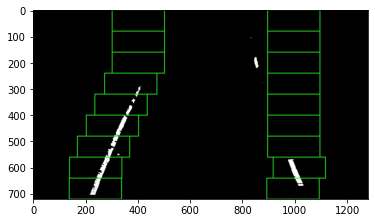

In [65]:
green_rectangles = cv2.imread('green_rectangles.jpg')
plt.imshow(green_rectangles)

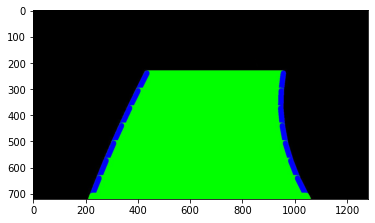

In [66]:
green_lane = cv2.imread('green_lane.jpg')
plt.imshow(green_lane)

In [67]:
class FindLaneLines:
    """ This class is for parameter tunning.

    Attributes:
        ...
    """
    def __init__(self):
        """ Init Application"""
        self.thresholding = Thresholding()
        self.transform = PerspectiveTransformation()
        self.lanelines = LaneLines()

    def forward(self, img):
        out_img = np.copy(img)
        img = self.transform.forward(img)
        thresholded_img = self.thresholding.forward(img)  
        green_rectangles, green_lanes = self.lanelines.forward(thresholded_img)  
        img = self.transform.backward(green_lanes)
        out_img = cv2.addWeighted(out_img, 1, img, 0.6, 0)  
        out_img = self.lanelines.plot(out_img, thresholded_img, green_lanes, green_rectangles)
        plt.imshow(out_img) 
        return out_img

    def process_image(self, input_path, output_path):
        img = mpimg.imread(input_path)
        out_img = self.forward(img)
        mpimg.imsave(output_path, out_img)

    def process_video(self, input_path, output_path):
        clip = VideoFileClip(input_path)
        out_clip = clip.fl_image(self.forward)
        out_clip.write_videofile(output_path, audio=False)

In [68]:
Video("challenge_video.mp4")

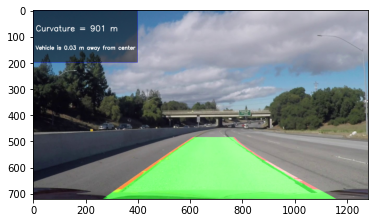

In [69]:
findLaneLines = FindLaneLines()
findLaneLines.process_image('test_images/challenge_video_frame_1.jpg', 'out.jpg')
# findLaneLines.process_video('challenge_video.mp4', 'output.mp4')

In [70]:
Video("output.mp4")